# Linear first order differential equation

In this toy example, we consider a first order linear differential equation

$$
 u'(t) = a u(t)
$$

with initial condition $u(t_0) = u_0$ true solution $u^\star(t) = u_0 e^{a(t -t_0)} $

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Import our package

In [2]:
import jinns

Import other dependencies

In [3]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx

import matplotlib.pyplot as plt

key = random.PRNGKey(2)
key, subkey = random.split(key)

2024-11-12 17:28:44.559211: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Create the neural network architecture for the PINN with `equinox`.

In [4]:
eqx_list = (
    (eqx.nn.Linear, 1, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 20),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 20, 1),
    # (jnp.exp,)
)
key, subkey = random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(key=subkey, eqx_list=eqx_list, eq_type="ODE")

Create a DataGenerator object

In [5]:
nt = 320
batch_size = 32
method = 'uniform'
tmin = 0
tmax = 1

Tmax = 1
key, subkey = random.split(key)
train_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=nt,
    tmin=tmin,
    tmax=tmax,
    temporal_batch_size=batch_size,
    method=method
)

### Model parameters




In [6]:
# initial conditions and growth
t0 = 0
u0 = 1.
a = 1.

In [7]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={"a": a},
)

Visualize the output of the neural networks before the parameter learning step

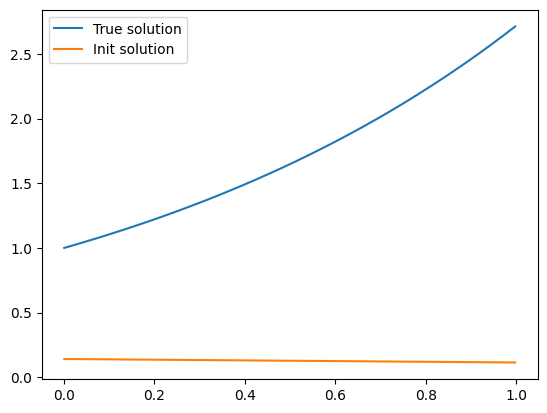

In [8]:
vectorized_u_init = vmap(lambda t: u(t, init_params), (0), 0)

def u_true(t):
    return u0 * jnp.exp(a * (t-t0) )

ts = train_data.times.sort(axis=0)
plt.plot(ts * Tmax, vmap(u_true, 0)(ts * Tmax), label="True solution")
plt.plot(ts * Tmax, vectorized_u_init(ts), label="Init solution")
plt.legend()

## Loss construction

In [9]:
from jinns.loss import ODE


class LinearFODE(ODE):

    def equation(self, t, u, params):
        # in log-space
        u_ = lambda t, p: u(t, p)[0]
        du_dt = jax.grad(u_, 0)(t, params)
        return du_dt - params.eq_params["a"]


fo_loss = LinearFODE(Tmax=Tmax)

In [10]:
loss_weights = jinns.loss.LossWeightsODE(dyn_loss=2.0, initial_condition=1.0)

loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=fo_loss,
    initial_condition=(float(tmin), jnp.log(u0)),
    params=init_params
)

In [11]:
# Testing the loss function
train_data, batch = train_data.get_batch()

losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    batch
)
l_tot, d = losses
print(f"total loss: {l_tot}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in d.items()} }")

total loss: 2.128390312194824
Individual losses: {'dyn_loss': '2.11', 'initial_condition': '0.02', 'observations': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [12]:
params = init_params

In [13]:
# Optimizer
import optax
tx = optax.adam(learning_rate=1e-4)

In [14]:
n_iter = int(10000)

In [15]:
key, subkey = random.split(key)

In [16]:
params, total_loss_list, loss_by_term_dict, data, loss, _, _ , _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter
)

Compilation took 1.190363883972168
[train] Iteration 0: loss value = 2.130326509475708
[train] Iteration 1000: loss value = 0.007776014972478151
[train] Iteration 2000: loss value = 0.003332656342536211
[train] Iteration 3000: loss value = 0.0016378058353438973
[train] Iteration 4000: loss value = 0.0007464339723810554
[train] Iteration 5000: loss value = 5.2385832532308996e-05
[train] Iteration 6000: loss value = 5.919089016970247e-05
[train] Iteration 7000: loss value = 4.0034912672126666e-05
[train] Iteration 8000: loss value = 4.708092092187144e-05
[train] Iteration 9000: loss value = 3.0921095458325e-05
Stopping main optimization loop, cause: max iteration is reached
Training took 2.509024143218994
Final iteration 10000: train loss value = 1.149815034295898e-05


## Results

Plot the loss values

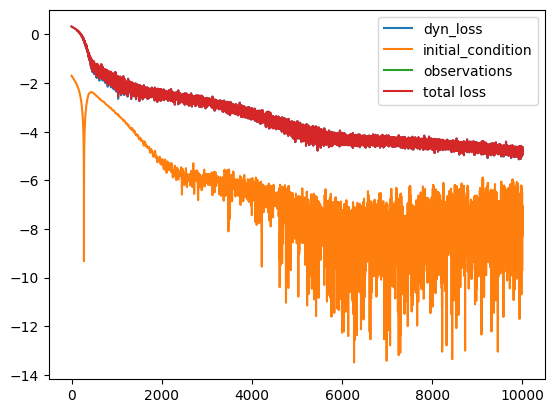

In [17]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show()

Plot the ODE solutions learned by the PINN

<Axes: xlabel='t'>

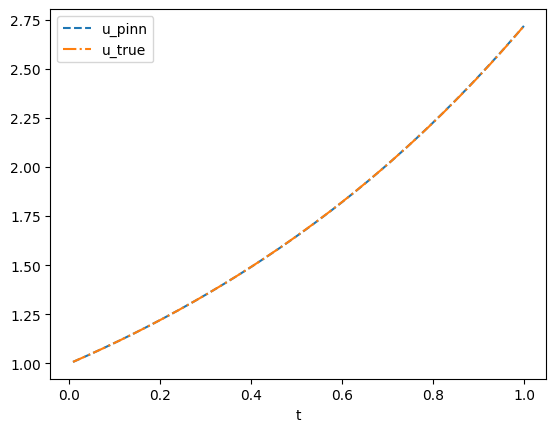

In [21]:
u_est_fp = vmap(lambda t:u(t, params), (0), 0)


key, subkey = random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(key=subkey, nt=nt, tmin=tmin, tmax=tmax, temporal_batch_size=batch_size, method=method)

import pandas as pd
ts = val_data.times.sort(axis=0).squeeze()
df = pd.DataFrame(
    {
        "t": ts * Tmax, # rescale time for plotting
        "u_pinn": jnp.exp(u_est_fp(ts).squeeze()),
        "u_true": vmap(u_true)(ts),
        "Method": "PINN"
    },
)
df.plot(x="t", style=["--", "-."])